This notebook takes our results extracted in ('1_make_tracks.ipynb') and breaks down the results and fluxes by PT. There are two sets of results, 'modelled' and 'mapped'. Modelled results use our calcualted dip angle and modelled slabs positions, while mapped refers to our approach that maps values onto the Slab2 surface. Default here is to plot the modelled results, but can be swapped to plot the mapped results instead.

In [2]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from cmcrameri import cm

In [3]:
# Some densities
perid_density_g_cm3 = 3.3  # g/cm3
perid_density_g_km3 = perid_density_g_cm3 * 100000**3
perid_density_kg_km3 = perid_density_g_km3 * 1e-3

In [6]:
# Load results from '1_make_tracks.ipynb'
with open('./data/subduction_tracks_2022-11-02_STD.pickle', 'rb') as f:
    tracks_STD = pickle.load(f)
with open('./data/subduction_tracks_2022-09-14.pickle', 'rb') as f:
    tracks = pickle.load(f)

In [7]:
# Get surface lat/long (i.e. present-day) of subduction zone (for worldview plots)
df_points_at_0_Ma = tracks[tracks['point_sub_times'] == 0]
latlon_points_at_0_Ma = np.vstack((df_points_at_0_Ma['point_lats'].values,
                                  df_points_at_0_Ma['point_lons'].values)).T

In [30]:
# Define P and T range based on extracted data, default is to show the
# modelled results rather than mapped results
# Mapped (Slab2) data 
#pressure_range = np.linspace(0,np.max(tracks['pressure_MODEL'].values),40)
#temp_range = np.linspace(0,np.max(tracks['temp_SYR10_MODEL'].values),40)
# Modelled results, 40 is an arbitrary number but gives a good balance
# between sample space and sample size
pressure_range = np.linspace(0,np.nanmax(tracks['pressure_SLAB2'].values),40)
temp_range = np.linspace(0,np.max(tracks['temp_SYR10_SLAB2'].values),40)

# Step through our pressure/temperature points and make a 2d matrix of bounds
pressure_steps = []
temp_steps = []
variables = []
for ind, (i,j) in enumerate(zip(temp_range, pressure_range)):
    if ind == len(temp_range)-1:
        break
    else:
        start_pressure = pressure_range[ind]
        final_pressure = pressure_range[ind+1]
        pressure_steps.append(([start_pressure, final_pressure]))
        start_temp = temp_range[ind]
        final_temp = temp_range[ind+1]
        temp_steps.append(([start_temp, final_temp]))

# Turn into an array
pressure_steps = np.asarray(pressure_steps)
temp_steps = np.asarray(temp_steps)

In [31]:
# Get PT stats, using bounds to extract data for a heatmap
total_peridotite = []
conditions = []
sub_segment_length = []

# Loop through our conditions
for ind, T_range in enumerate(temp_steps):
    for ind2, rho_range in enumerate(pressure_steps):

        # Define our target conditions
        target_temp = T_range
        target_pressure = rho_range
        conditions.append([T_range, rho_range])
        
        # Loop through tracks
        # Mapped results
        #for ind3, track in enumerate(tracks):
        #tmp_df =  tracks[(tracks['temp_SYR10_MODEL'] > target_temp[0])
        #               & (tracks['temp_SYR10_MODEL'] < target_temp[1])
        #               & (tracks['pressure_MODEL'] > target_pressure[0])
        #               & (tracks['pressure_MODEL'] < target_pressure[1])]

        # Modelled results
        tmp_df =  tracks[(tracks['temp_SYR10_SLAB2'] > target_temp[0])
                       & (tracks['temp_SYR10_SLAB2'] < target_temp[1])
                       & (tracks['pressure_SLAB2'] > target_pressure[0])
                       & (tracks['pressure_SLAB2'] < target_pressure[1])]
        perid_volume = tmp_df['volume_perids'].values
        total_peridotite.append(np.sum(perid_volume))
        
#conver to array
conditions = np.asarray(conditions)
total_peridotite = np.asarray(total_peridotite)


In [33]:
# Make a meshgrid for plots
y, x = np.meshgrid(pressure_steps[:,0], temp_steps[:,0])
# Reshape data
#h2_reshape = np.reshape(total_h2, np.shape(y))
perid_reshape = np.reshape(total_peridotite, np.shape(y))

Text(0.5, 0.98, 'modelled RAP')

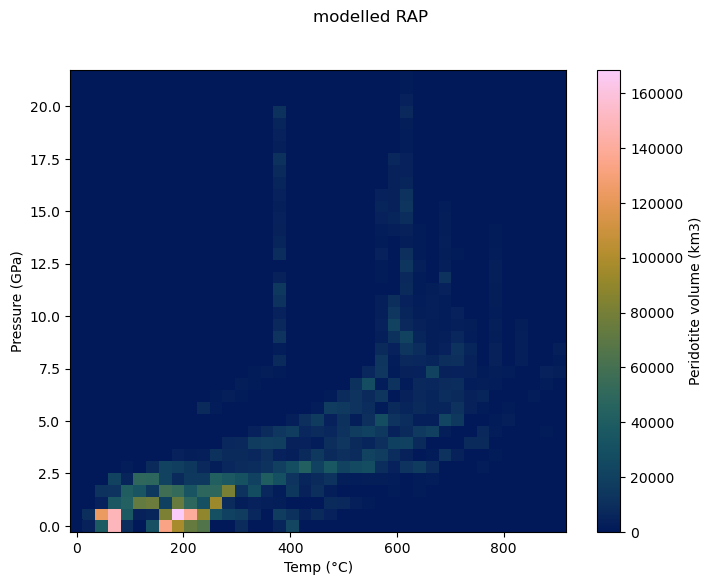

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,6))
c = ax.pcolor(x, y, perid_reshape, zorder=0, cmap=cm.batlow)
ax.set_ylabel('Pressure (GPa)')
ax.set_xlabel('Temp (°C)')
cbar = fig.colorbar(c, ax=ax)
cbar.set_label('Peridotite volume (km3)')
fig.suptitle('modelled RAP')  

In [ ]:
# Save results out
df_results = pd.DataFrame({'total_peridotite':total_peridotite})
df_results.to_csv('./results/PT_results_2022_Sep_v2.csv')